$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## Convolution

### Neural and hemodynamic models

In functional MRI (FMRI), we often have the subjects do a task in the scanner.
For example, we might have the subject lying looking at a fixation cross on
the screen for most of the time, and sometimes show a very brief burst of
visual stimulation, such as a flashing checkerboard.

We will call each burst of stimulation an *event*.

The FMRI signal comes about first through changes in neuronal firing, and then
by blood flow responses to the changes in neuronal firing.  In order to
predict the FMRI signal to an event, we first need a prediction (model) of the
changes in neuronal firing, and second we need a prediction (model) of how
the blood flow will change in response to the neuronal firing.

So we have a two-stage problem:

* predict the neuronal firing to the event (make a *neuronal firing model*);

* predict the blood flow changes caused by the neuronal firing (a *hemodynamic
  model*).

[Convolution](https://en.wikipedia.org/wiki/Convolution) is a simple way to create a hemodynamic model from a neuronal
firing model.

#### The neuronal firing model

The neuronal firing model is our prediction of the profile of neural activity
in response to the event.

For example, in this case, with a single stimulation, we might predict that,
as soon as the visual stimulation went on, the cells in the visual cortex
instantly increased their firing, and kept firing at the same rate while the
stimulation was on.

In that case, our *neural* model of an event starting at 4 seconds, lasting 5
seconds, might look like this:

In [1]:
#Visualize the effect of inputs into hemodynamic response function

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def hrf(t, x, y):
    """A hemodynamic response function"""
    return t ** x * np.exp(-t / y)

def visualize_hrf(x=8, y=0.5):
    t = np.linspace(0, 20, 1000)  # Adjust the range of t as needed
    response = hrf(t, x, y)
    plt.plot(t, response)
    plt.title('Hemodynamic Response Function')
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.grid(True)
    plt.show()

# Define sliders
x_slider = FloatSlider(value=8, min=5, max=12, step=0.1, description='x:')
y_slider = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='y:')

# Create interactive plot
interact(visualize_hrf, x=x_slider, y=y_slider);


interactive(children=(FloatSlider(value=8.0, description='x:', max=12.0, min=5.0), FloatSlider(value=0.5, desc…

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Text(0.5, 1.0, 'Neural model for 5 second event starting at time 4')

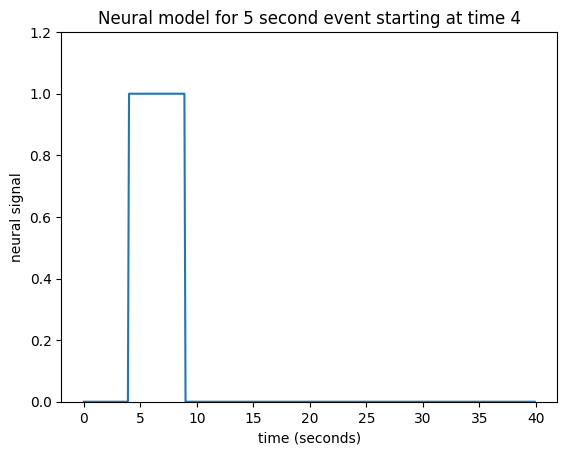

In [3]:
times = np.arange(0, 40, 0.1)
n_time_points = len(times)
neural_signal = np.zeros(n_time_points)
neural_signal[(times >= 4) & (times < 9)] = 1
plt.plot(times, neural_signal)
plt.xlabel('time (seconds)')
plt.ylabel('neural signal')
plt.ylim(0, 1.2)
plt.title("Neural model for 5 second event starting at time 4")

This type of simple off - on - off model is a [boxcar function](https://en.wikipedia.org/wiki/Boxcar_function).

Of course we could have had another neural model, with the activity gradually
increasing, or starting high and then dropping, but let us stick to this
simple model for now.

Now we need to predict our hemodynamic signal, given our prediction of neuronal
firing.

# The impulse response

Let’s simplify a little by specifying that the event was really short.  Call
this event — an *impulse*.  This simplifies our neural model to a single
spike in time instead of the sustained rise of the box-car function.

Text(0.5, 1.0, 'Neural model for very brief event at time 4')

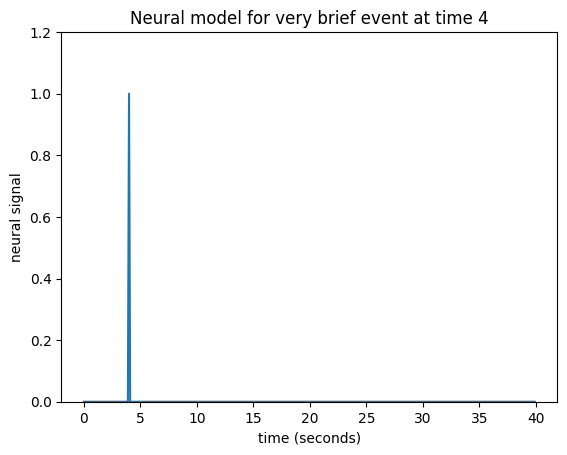

In [4]:
neural_signal = np.zeros(n_time_points)
i_time_4 = np.where(times == 4)[0][0]  # index of value 4 in "times"
neural_signal[i_time_4] = 1  # A single spike at time == 4
plt.plot(times, neural_signal)
plt.xlabel('time (seconds)')
plt.ylabel('neural signal')
plt.ylim(0, 1.2)
plt.title("Neural model for very brief event at time 4")

Let us now imagine that I know what the hemodynamic *response* will be to such
an impulse.  I might have got this estimate from taking the FMRI signal
following very brief events, and averaging over many events.  Here is one such
estimate of the hemodynamic *response* to a very brief stimulus:

In [7]:
def hrf(t):
    "A hemodynamic response function"
    return t ** 8.6 * np.exp(-t / 0.547)

Text(0.5, 1.0, 'Estimated BOLD signal for event at time 0')

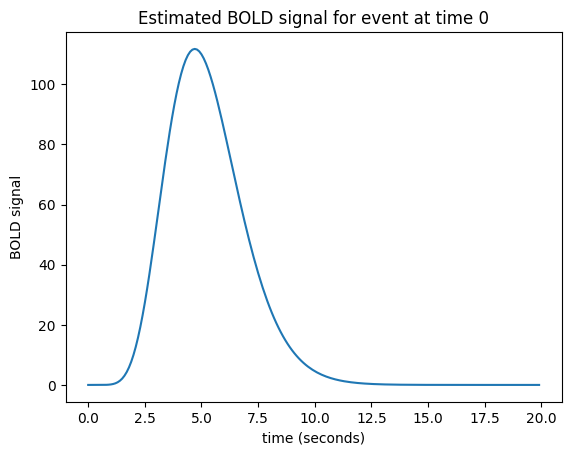

In [8]:
hrf_times = np.arange(0, 20, 0.1)
hrf_signal = hrf(hrf_times)
plt.plot(hrf_times, hrf_signal)
plt.xlabel('time (seconds)')
plt.ylabel('BOLD signal')
plt.title('Estimated BOLD signal for event at time 0')

This is the hemodynamic response to a neural impulse.  In signal processing
terms this is the hemodynamic [impulse response function](impulseresponse).
It is usually called the hemodynamic response function (HRF), because it is a
function that gives the predicted hemodynamic response at any given time
following an impulse at time 0.

# Building the hemodynamic output from the neural input

We now have an easy way to predict the hemodynamic output from our single impulse
at time 4.  We take the HRF (prediction for an impulse starting at time 0), and
shift it by 4 seconds-worth to give our predicted output:

Text(0.5, 1.0, 'Output BOLD signal for event at time=4')

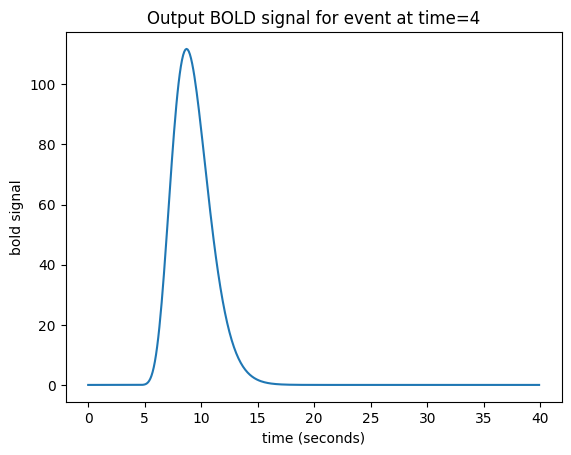

In [9]:
n_hrf_points = len(hrf_signal)
bold_signal = np.zeros(n_time_points)
bold_signal[i_time_4:i_time_4 + n_hrf_points] = hrf_signal
plt.plot(times, bold_signal)
plt.xlabel('time (seconds)')
plt.ylabel('bold signal')
plt.title('Output BOLD signal for event at time=4')

Our impulse so far has an amplitude of 1.  What if the impulse was twice as
strong, with an amplitude of 2?

In [ ]:
neural_signal[i_time_4] = 2  # An impulse with amplitude 2
plt.plot(times, neural_signal)
plt.xlabel('time (seconds)')
plt.ylabel('neural signal')
plt.ylim(0, 2.2)
plt.title('Neural model for amplitude 2 impulse')

Maybe I can make the assumption that, if the impulse is twice as large then the
response will be twice as large.  This is the assumption that the response
scales linearly with the impulse.

Now I can predict the output for an impulse of amplitude 2 by taking my HRF,
shifting by 4, as before, and then multiplying the HRF by 2:

In [ ]:
bold_signal = np.zeros(n_time_points)
bold_signal[i_time_4:i_time_4 + n_hrf_points] = hrf_signal * 2
plt.plot(times, bold_signal)
plt.xlabel('time (seconds)')
plt.ylabel('bold signal')
plt.title('Output BOLD signal for amplitude 2 impulse')

What if I have several impulses?  For example, imagine I had an impulse
amplitude 2 at time == 4, then another of amplitude 1 at time == 10, and another
of amplitude 3 at time == 20.

In [ ]:
neural_signal[i_time_4] = 2  # An impulse with amplitude 2
i_time_10 = np.where(times == 10)[0][0]  # index of value 10 in "times"
neural_signal[i_time_10] = 1  # An impulse with amplitude 1
i_time_20 = np.where(times == 20)[0][0]  # index of value 20 in "times"
neural_signal[i_time_20] = 3  # An impulse with amplitude 3
plt.plot(times, neural_signal)
plt.xlabel('time (seconds)')
plt.ylabel('neural signal')
plt.ylim(0, 3.2)
plt.title('Neural model for three impulses')

Maybe I can also make the assumption that the response to an impulse will be
exactly the same over time.  The response to any given impulse at time 10 will
be the same as the response to the same impulse at time 4 or at time 30.

In that case my job is still simple.  For the impulse amplitude 2 at time == 4,
I add the HRF shifted to start at time == 4, and scaled by 2.  To that result I
then add the HRF shifted to time == 10 and scaled by 1.  Finally, I further add
the HRF shifted to time == 20 and scaled by 3:

In [ ]:
bold_signal = np.zeros(n_time_points)
bold_signal[i_time_4:i_time_4 + n_hrf_points] = hrf_signal * 2
bold_signal[i_time_10:i_time_10 + n_hrf_points] += hrf_signal * 1
bold_signal[i_time_20:i_time_20 + n_hrf_points] += hrf_signal * 3
plt.plot(times, bold_signal)
plt.xlabel('time (seconds)')
plt.ylabel('bold signal')
plt.title('Output BOLD signal for three impulses')

At the moment, an *impulse* is an event that lasts for just one time point. In
our case, the time vector (`times` in the code above) has one point for every
0.1 seconds (10 time points per second).

What happens if an event lasts for 0.5 seconds?  Maybe I can assume that an
event lasting 0.5 seconds has exactly the same effect as 5 impulses 0.1
seconds apart:

In [ ]:
neural_signal[i_time_4:i_time_4 + 5] = 2
plt.plot(times, neural_signal)
plt.xlabel('time (seconds)')
plt.ylabel('neural signal')
plt.ylim(0, 3.2)
plt.title('Neural model including event lasting 0.5 seconds')

Now I need to add a new shifted HRF for the impulse corresponding to time == 4,
and for time == 4.1 and so on until time == 4.4:

In [ ]:
bold_signal = np.zeros(n_time_points)
for i in range(5):
    bold_signal[i_time_4 + i:i_time_4  + i + n_hrf_points] += hrf_signal * 2
bold_signal[i_time_10:i_time_10 + n_hrf_points] += hrf_signal * 1
bold_signal[i_time_20:i_time_20 + n_hrf_points] += hrf_signal * 3
plt.plot(times, bold_signal)
plt.xlabel('time (seconds)')
plt.ylabel('bold signal')
plt.title('Output BOLD signal with event lasting 0.5 seconds')

# Working out an algorithm

Now we have a general algorithm for making our output hemodynamic signal from
our input neural signal:

1. Start with an output vector that is a vector of zeros;

1. For each index $i$ in the *input vector* (the neural signal):

   > 1. Prepare a shifted copy of the HRF vector, starting at $i$. Call this the
   >    *shifted HRF vector*;

   > 1. Multiply the shifted HRF vector by the value in the input at index $i$,
   >    to give the *shifted, scaled HRF vector*;

   > 1. Add the shifted scaled HRF vector to the output.

There is a little problem with our algorithm — the length of the output
vector.

Imagine that our input (neural) vector is N time points long.  Say the original
HRF vector is M time points long.

In our algorithm, when the iteration gets to the last index of the *input
vector* ($i = N-1$), the shifted scaled HRF vector will, as ever, be M points
long.  If the output vector is the same length as the input vector, we can add
only the first point of the new scaled HRF vector to the last point of the
output vector, but all the subsequent values of the scaled HRF vector extend
off the end of the output vector and have no corresponding index in the
output.  The way to solve this is to extend the output vector by the necessary
M-1 points. Now we can do our algorithm in code.

Text(0.5, 1.0, 'Output BOLD signal using our algorithm')

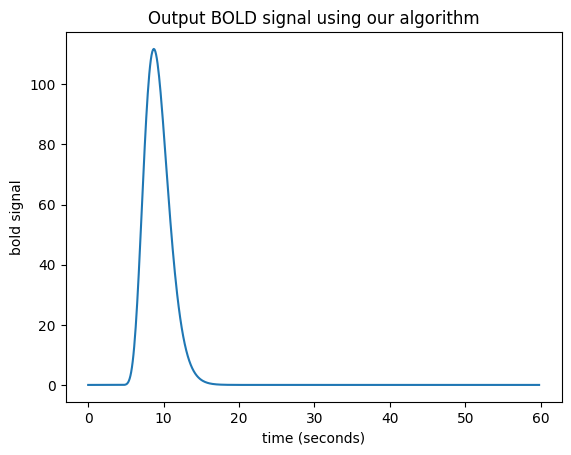

In [11]:
N = n_time_points
M = n_hrf_points
bold_signal = np.zeros(N + M - 1)  # adding the tail
for i in range(N):
    input_value = neural_signal[i]
    # Adding the shifted, scaled HRF
    bold_signal[i : i + n_hrf_points] += hrf_signal * input_value
# We have to extend 'times' to deal with more points in 'bold_signal'
extra_times = np.arange(n_hrf_points - 1) * 0.1 + 40
times_and_tail = np.concatenate((times, extra_times))
plt.plot(times_and_tail, bold_signal)
plt.xlabel('time (seconds)')
plt.ylabel('bold signal')
plt.title('Output BOLD signal using our algorithm')

In [16]:
extra_times

array([40. , 40.1, 40.2, 40.3, 40.4, 40.5, 40.6, 40.7, 40.8, 40.9, 41. ,
       41.1, 41.2, 41.3, 41.4, 41.5, 41.6, 41.7, 41.8, 41.9, 42. , 42.1,
       42.2, 42.3, 42.4, 42.5, 42.6, 42.7, 42.8, 42.9, 43. , 43.1, 43.2,
       43.3, 43.4, 43.5, 43.6, 43.7, 43.8, 43.9, 44. , 44.1, 44.2, 44.3,
       44.4, 44.5, 44.6, 44.7, 44.8, 44.9, 45. , 45.1, 45.2, 45.3, 45.4,
       45.5, 45.6, 45.7, 45.8, 45.9, 46. , 46.1, 46.2, 46.3, 46.4, 46.5,
       46.6, 46.7, 46.8, 46.9, 47. , 47.1, 47.2, 47.3, 47.4, 47.5, 47.6,
       47.7, 47.8, 47.9, 48. , 48.1, 48.2, 48.3, 48.4, 48.5, 48.6, 48.7,
       48.8, 48.9, 49. , 49.1, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8,
       49.9, 50. , 50.1, 50.2, 50.3, 50.4, 50.5, 50.6, 50.7, 50.8, 50.9,
       51. , 51.1, 51.2, 51.3, 51.4, 51.5, 51.6, 51.7, 51.8, 51.9, 52. ,
       52.1, 52.2, 52.3, 52.4, 52.5, 52.6, 52.7, 52.8, 52.9, 53. , 53.1,
       53.2, 53.3, 53.4, 53.5, 53.6, 53.7, 53.8, 53.9, 54. , 54.1, 54.2,
       54.3, 54.4, 54.5, 54.6, 54.7, 54.8, 54.9, 55

In [15]:
# hrf_signal

# We have *convolution*

We now have — convolution.  Here’s the same thing using the numpy
`convolve` function:

Text(0.5, 1.0, 'Our algorithm is the same as convolution')

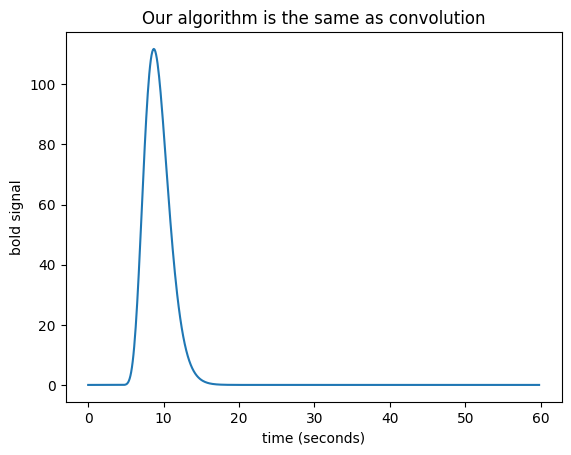

In [12]:
bold_signal = np.convolve(neural_signal, hrf_signal)
plt.plot(times_and_tail, bold_signal)
plt.xlabel('time (seconds)')
plt.ylabel('bold signal')
plt.title('Our algorithm is the same as convolution')

# Convolution with matrices

For what follows, it is a bit easier to see what is going on with a lower time
resolution — say one time point per second.  This time we’ll make the first
event last 3 seconds:

In [ ]:
times = np.arange(0, 40)  # One time point per second
n_time_points = len(times)
neural_signal = np.zeros(n_time_points)
neural_signal[4:7] = 1  # A 3 second event
neural_signal[10] = 1
neural_signal[20] = 3
hrf_times = np.arange(20)
hrf_signal = hrf(hrf_times)  # The HRF at one second time resolution
n_hrf_points = len(hrf_signal)
bold_signal = np.convolve(neural_signal, hrf_signal)
times_and_tail = np.arange(n_time_points + n_hrf_points - 1)
fig, axes = plt.subplots(3, 1, figsize=(8, 15))
axes[0].plot(times, neural_signal)
axes[0].set_title('Neural signal, 1 second resolution')
axes[1].plot(hrf_times, hrf_signal)
axes[1].set_title('Hemodynamic impulse response, 1 second resolution')
axes[2].plot(times_and_tail, bold_signal)
axes[2].set_title('Predicted BOLD signal from convolution, 1 second resolution')

Our algorithm, which turned out to give convolution, had us add a shifted,
scaled version of the HRF to the output, for every index.  This is step 5 of our
algorithm.

Now let us go back to our convolution algorithm.  Imagine that, instead of
adding the shifted scaled HRF to the output vector, we store each shifted scaled
HRF as a row in an array, that has one row for each index in the input vector.
Then we can get the same output vector as before by taking the sum across the
columns of this array:

In [ ]:
N = n_time_points
M = n_hrf_points
shifted_scaled_hrfs = np.zeros((N, N + M - 1))
for i in range(N):
    input_value = neural_signal[i]
    # Storing the shifted, scaled HRF
    shifted_scaled_hrfs[i, i : i + n_hrf_points] = hrf_signal * input_value
bold_signal_again = np.sum(shifted_scaled_hrfs, axis=0)

In [ ]:
# We check that the result is almost exactly the same
# (allowing for tiny differences due to the order of +, * operations)
import numpy.testing as npt
npt.assert_almost_equal(bold_signal, bold_signal_again)

We can also do exactly the same operation by first making an array with the
*shifted* HRFs, without scaling, and then multiplying each row by the
corresponding input value, before doing the sum.  Here we are doing the shifting
first, and then the scaling, and then the sum.  It all adds up to the same
operation:

In [ ]:
# First we make the shifted HRFs
shifted_hrfs = np.zeros((N, N + M - 1))
for i in range(N):
    # Storing the shifted HRF without scaling
    shifted_hrfs[i, i : i + n_hrf_points] = hrf_signal
# Then do the scaling
shifted_scaled_hrfs = np.zeros((N, N + M - 1))
for i in range(N):
    input_value = neural_signal[i]
    # Scaling the stored HRF by the input value
    shifted_scaled_hrfs[i, :] = shifted_hrfs[i, :] * input_value
# Then the sum
bold_signal_again = np.sum(shifted_scaled_hrfs, axis=0)
# This gives the same result, once again
npt.assert_almost_equal(bold_signal, bold_signal_again)

The `shifted_hrfs` array looks like this as an image:

In [ ]:
plt.imshow(shifted_hrfs, cmap='gray', interpolation='nearest')

Each new row of `shifted_hrfs` corresponds to the HRF, shifted by one more
column to the right:

In [ ]:
fig, axes = plt.subplots(5, 1)
for row_no in range(5):
    axes[row_no].plot(shifted_hrfs[row_no, :])

Now remember matrix multiplication:

$$
\begin{pmatrix}
    xa + yb + zc   \\
    xd + ye + zf
\end{pmatrix}
=
\begin{pmatrix}
    x & y & z
\end{pmatrix}
\begin{pmatrix}
    a & d \\
    b & e \\
    c & f
\end{pmatrix}
$$

Now let us make our input neural vector into a 1 by N row vector.  If we *matrix
multiply* this vector onto the `shifted_hrfs` array (matrix), then we do the
scaling of the HRFs and the sum operation, all in one go.  Like this:

In [ ]:
def as_row_vector(v):
    " Convert 1D vector to row vector "
    return v.reshape((1, -1))

In [ ]:
neural_vector = as_row_vector(neural_signal)
# The scaling and summing by the magic of matrix multiplication
bold_signal_again = neural_vector.dot(shifted_hrfs)
# This gives the same result as previously, yet one more time
npt.assert_almost_equal(as_row_vector(bold_signal), bold_signal_again)

The matrix transpose rule says $(A B)^T = B^T A^T$ where $A^T$ is the transpose
of matrix $A$.  So we could also do this exact same operation by doing a matrix
multiply of the transpose of `shifted_hrfs` onto the `neural_signal` as a
column vector:

In [ ]:
bold_signal_again = shifted_hrfs.T.dot(neural_vector.T)
# Exactly the same, but transposed
npt.assert_almost_equal(as_row_vector(bold_signal), bold_signal_again.T)

In this last formulation, the `shifted_hrfs` matrix is the *convolution*
matrix, in that (as we have just shown) you can apply the convolution of the
HRF by matrix multiplying onto an input vector.

# Convolution is like cross-correlation with the reversed HRF

We are now ready to show something slightly odd that arises from the way that
convolution works.

Consider index $i$ in the input (neural) vector.  Let’s say $i = 25$.  We want to get
value index $i$ in the output (hemodynamic vector). What do we need to do?

Looking at our non-transposed matrix formulation, we see that value $i$ in the
output is the matrix multiplication of the neural signal (row vector) by
column $i$ in `shifted_hrfs`.  Here is a plot of column 25 in
`shifted_hrfs`:

In [ ]:
plt.plot(shifted_hrfs[:, 25])

The column contains a *reversed* copy of the HRF signal, where the first value
from the original HRF signal is at index 25 ($i$), the second value is at
index 24 ($i - 1$) and so on back to index 25 - 20 = 5.  The reversed HRF
follows from the way we constructed the rows of the original matrix.  Each new
HRF row was shifted across by one column, therefore, reading up the columns
from the diagonals, will also give you the HRF shape.

Let us rephrase the matrix multiplication that gives us the value at index $i$
in the output vector.  Call the neural input vector $\mathbf{n}$ with values
$n_0, n_1 ... n_{N-1}$.  Call the `shifted_hrfs` array $\mathbf{S}$ with $N$
rows and $N + M - 1$ columns.  $\mathbf{S}_{:,i}$ is column $i$ in
$\mathbf{S}$.

So, the output value $o_i$ is given by the matrix multiplication of row
$\mathbf{n}$ onto column $\mathbf{S}_{:,i}$.  The matrix multiplication (dot
product) gives us the usual sum of products as the output:

$$
o_i = \sum_{j=0}^{N-1}{n_j S_{j,i}}
$$

The formula above describes what is happening in the matrix multiplication in
this piece of code:

In [ ]:
i = 25
bold_i = neural_vector.dot(shifted_hrfs[:, i])

In [ ]:
npt.assert_almost_equal(bold_i, bold_signal[i])

Can we simplify the formula without using the `shifted_hrfs` $\mathbf{S}$
matrix?  We saw above that column $i$ in `shifted_hrfs` contains a reversed
HRF, starting at index $i$ and going backwards towards index 0.

The 1-second resolution HRF is our array `hrf_signal`.  So `shifted_hrfs[i,
i]` contains `hrf_signal[0]`, `shifted_hrfs[i-1, i]` contains
`hrf_signal[1]` and so on.  In general, for any index $j$ into
`shifted_hrfs[:, i]`, `shifted_hrfs[j, i] == hrf_signal[i-j]` (assuming
we return zero for any `hrf_signal[i-j]` where `i-j` is outside the
bounds of the vector, with `i-j` < 0 or >= M).

Realizing this, we can replace $\mathbf{S}_{:,i}$ in our equation above.  Call
our `hrf_signal` vector $\mathbf{h}$ with values $h_0, h_1, ... h_{M-1}$.
Then:

$$
o_i = \sum_{j=0}^{N-1}{n_j h_{i-j}}
$$

This is the sum of the {products of the elements of $\mathbf{n}$ with the
matching elements from the [reversed HRF vector $\mathbf{h}$, shifted by $i$
elements]}.

# The mathematical definition for convolution

This brings us to the abstract definition of convolution for continuous
functions.

In general, call the continuous input a function $f$.  In our case the input
signal is the neuronal model, that is a function of time.  This is the
continuous generalization of the vector $\mathbf{n}$ in our discrete model.
The continuous function to convolve with is $g$.  In our case $g$ is the HRF,
also a function of time.  $g$ is the generalized continuous version of the
vector $\mathbf{h}$ in the previous section.  The convolution of $f$ and $g$
is often written $(f * g)$ and for any given $t$ is defined as:

$$
(f * g )(t) \stackrel{\mathrm{def}}{=}\ \int_{-\infty}^\infty f(\tau)\,
g(t - \tau)\, d\tau
$$

As you can see, and as we have already discovered in the discrete case, the
convolution is the integral of the product of the two functions as the second
function $g$ is reversed and shifted.

See : the [wikipedia convolution definition section](https://en.wikipedia.org/wiki/Convolution#Definition) for more discussion.

<!-- A file containing links and substitutions -->
<!-- vim: ft=rst -->
<!-- Version control -->
<!-- Editors -->
<!-- Python and common libraries -->
<!-- Virtualenv and helpers -->
<!-- Pypi and packaging -->
<!-- Mac development -->
<!-- Windows development -->
<!-- Nipy and friends -->
<!-- Mathematics -->
<!-- Licenses -->
<!-- Neuroimaging stuff -->
<!-- People -->
<!-- Substitutions -->